In [ ]:
import random
import time
import os

from IPython.display import clear_output

import torch
from torch import nn, optim, cuda
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchmetrics
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
BS = 32

In [ ]:
device = 'cpu'
if cuda.is_available():
    device_name = cuda.get_device_name(0)
    memory = cuda.get_device_properties(0).total_memory / (1024 ** 3)
    print(f"Device {device_name} has {memory} GB of memory")
    device = torch.device('cuda')
else:
    raise Exception("Cuda isn't available")
device

Device NVIDIA GeForce RTX 3060 Ti has 7.9993896484375 GB of memory


device(type='cuda')

In [12]:
train_transform = transforms.Compose([
    transforms.Resize([224, 224], antialias=False),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.RandomResizedCrop(224, antialias=False),
    transforms.ConvertImageDtype(dtype=torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


val_transform = transforms.Compose([
    transforms.Resize([224, 224], antialias=False),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(dtype=torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
train_dataset = datasets.ImageFolder(root='./dataset/tr', transform=train_transform)
val_dataset = datasets.ImageFolder(root='./dataset/val', transform=val_transform)
test_dataset = datasets.ImageFolder(root='./dataset/test', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)

In [14]:
from collections import Counter

train_labels = train_dataset.targets
val_labels = val_dataset.targets
test_labels = test_dataset.targets

class_counts_train = Counter(train_labels)
class_counts_val = Counter(val_labels)
class_counts_test = Counter(test_labels)

print("Train Dataset Class Counts:")
for class_index, count in class_counts_train.items():
    class_name = train_dataset.classes[class_index]
    print(f"{class_name}: {count}")

print("Val Dataset Class Counts:")
for class_index, count in class_counts_val.items():
    class_name = val_dataset.classes[class_index]
    print(f"{class_name}: {count}")

print("Test Dataset Class Counts:")
for class_index, count in class_counts_test.items():
    class_name = test_dataset.classes[class_index]
    print(f"{class_name}: {count}")


Train Dataset Class Counts:
hotdog: 1253
nothotdog: 1253
Val Dataset Class Counts:
hotdog: 247
nothotdog: 247
Test Dataset Class Counts:
hotdog: 322
nothotdog: 322


In [15]:
try:
  if model:
    model.zero_grad()
    del model
    torch.cuda.empty_cache()
    print('model has been deleted')
except:
  print('model doesnt exist')

model has been deleted


In [16]:
model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
num_features = model.fc.in_features
# model.fc = nn.Sequential(
#     nn.Linear(num_features, 1),
#     nn.Sigmoid()
# )
model.fc = nn.Sequential(
    nn.Linear(num_features, 2),
    nn.Softmax(dim=1)
)
# model.fc = nn.Sequential(
#     nn.Linear(num_features, 512),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(512, 2),
#     nn.Softmax()
# )

model = model.to(device)
criterion = nn.CrossEntropyLoss()
model

KeyboardInterrupt: 

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
num_epochs = 100
lr_scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

len_loader = len(train_loader)

accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=2).to(device)
precision = torchmetrics.Precision(task='multiclass', num_classes=2).to(device)
recall = torchmetrics.Recall(task='multiclass', num_classes=2).to(device)
f1 = torchmetrics.F1Score(task='multiclass', num_classes=2).to(device)

C:\Users\kuzga\AppData\Local\Temp\ipykernel_17276\298371448.py:164: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(x_vals[::5], rotation=90)


<Figure size 640x480 with 0 Axes>

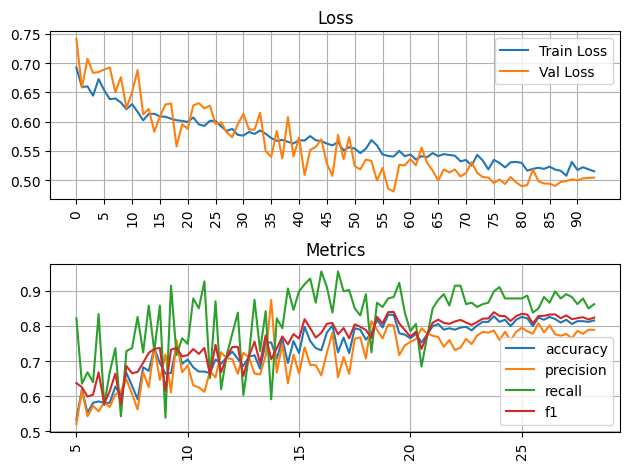

[0.6923649786393854, 0.6590119634248033, 0.6601324873634532, 0.6442760214020934, 0.6725363195696964, 0.653532079503506, 0.6382748910897895, 0.6394092606592782, 0.6326043975504139, 0.6211233980293516, 0.6297706120376345, 0.6166454779950878, 0.6021271751651281, 0.613159233633476, 0.6132920403269273, 0.6087781696379939, 0.6082382964182503, 0.6047799975811681, 0.6022881276999847, 0.6011806666096554, 0.5994167184527917, 0.6070047632048402, 0.5951276202745075, 0.5925124653532535, 0.6013559163371219, 0.6010181590726104, 0.5918367810641663, 0.5838689773897582, 0.5875420917438555, 0.5772728667229037, 0.5760042275054545, 0.5823458203032047, 0.5788928176028819, 0.5846813064587267, 0.5792209298550328, 0.5718607355522204, 0.5668790385692934, 0.5686245802082593, 0.5654460135139997, 0.562630278400228, 0.5680941584744031, 0.5675483621373961, 0.575271872779991, 0.5680536839026439, 0.5666521757463866, 0.5623226388345791, 0.5593693595898303, 0.5650951205929623, 0.5506572632849971, 0.5562715926502324, 0.5

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:
x_vals = []
train_losses = []
val_losses = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []


runs_dir = "runs"
os.makedirs(runs_dir, exist_ok=True)
existing_runs = [d for d in os.listdir(runs_dir) if os.path.isdir(os.path.join(runs_dir, d))]


if existing_runs:
    max_index = max([int(d.split("run")[1]) for d in existing_runs])
    new_run_index = max_index + 1
else:
    new_run_index = 1

current_run_dir = os.path.join(runs_dir, f"run{new_run_index}")
os.makedirs(current_run_dir, exist_ok=True)

train_stats_file = os.path.join(current_run_dir, "train_stats.txt")
test_stats_file = os.path.join(current_run_dir, "test_stats.txt")
best_model_weights_file = os.path.join(current_run_dir, "best.pth")

with open(train_stats_file, 'w') as f:
    f.write(f"{model.__class__.__name__} for {num_epochs} epochs\n")

best_val_loss = float('inf')
best_val_accuracy = 0.0
best_epoch = 0


start = time.time()
for epoch in range(num_epochs):
    print(f'\rEpoch: {epoch} / {num_epochs}')
    x_vals.append(epoch)
    model.train()
    i = 1
    running_loss = 0.0
    val_running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        print(f"\r Train batch {batch_idx}/{len(train_loader)}", end='', flush=True)
        # if i % 10 == 0:
            # print(f'/rIteration: {i} / {len_loader}', end='', flush=True)
        i += 1
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        # print(f"Outputs {outputs}")
        # predicted = (outputs > 0.5).float()
        predicted = torch.argmax(outputs, dim=1)
        # print(f"labels: {labels}/nrped: {predicted}")

        # loss = criterion(outputs, labels.unsqueeze(1).float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    # print(f"/nTrain loss: {epoch_train_loss}")
    print('\n')


    lr_scheduler.step()
    model.eval()

    acc_sum = 0
    pres_sum = 0
    recall_sum = 0
    f1_sum = 0

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            print(f"\r Val batch {batch_idx}/{len(val_loader)}", end='', flush=True)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)


            TP += ((predicted == 1) & (labels == 1)).sum().item()
            FP += ((predicted == 1) & (labels == 0)).sum().item()
            TN += ((predicted == 0) & (labels == 0)).sum().item()
            FN += ((predicted == 0) & (labels == 1)).sum().item()

            my_accuracy = (TP + TN) / (TP + FP + TN + FN)
            my_precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            my_recall = TP / (TP + FN) if (TP + FN) > 0 else 0
            my_f1 = 2 * (my_precision * my_recall) / (my_precision + my_recall) if (my_precision + my_recall) > 0 else 0


            accuracy.update(predicted, labels)
            precision.update(predicted, labels)
            recall.update(predicted, labels)
            f1.update(predicted, labels)


        epoch_val_loss = val_running_loss / len(val_loader)
        val_losses.append(epoch_val_loss)

        val_acc = accuracy.compute().item()
        val_prec = precision.compute().item()
        val_recall = recall.compute().item()
        val_f1 = f1.compute().item()

        accuracy.reset()
        precision.reset()
        recall.reset()
        f1.reset()

        accuracy_list.append(my_accuracy)
        precision_list.append(my_precision)
        recall_list.append(my_recall)
        f1_list.append(my_f1)


        if epoch_val_loss < best_val_loss:
        # if val_acc < best_val_accuracy:
            best_val_loss = epoch_val_loss
            best_val_accuracy = val_acc
            best_epoch = epoch
            torch.save(model.state_dict(), best_model_weights_file)
            dur = time.time() - start
            with open(train_stats_file, "a") as f:
                f.write(f"Epoch {epoch + 1} / {num_epochs}: Train Loss: {epoch_train_loss}, Val Loss: {epoch_val_loss}, Val Accuracy: {val_acc} Dur: {dur} Dur/Epoch: {dur / epoch if epoch != 0 else 0}\n")
        elif epoch > best_epoch + (num_epochs // 2):
            print(f"\nTraining has stopped at {epoch} / {num_epochs} cuz val loss didn't decrease for {num_epochs // 2} epochs")
            break


        clear_output(wait=True)
        #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        fig, (ax1, ax2) = plt.subplots(2, 1)
        ax1.plot(x_vals, train_losses, label='Train Loss')
        ax1.plot(x_vals, val_losses, label='Val Loss')
        ax1.legend()
        ax1.grid(True)
        ax1.set_xticks(x_vals[::5])
        ax1.set_xticklabels(x_vals[::5], rotation=90)
        ax1.set_title('Loss')

        # Второй график
        ax2.plot(x_vals, accuracy_list, label='accuracy')
        ax2.plot(x_vals, precision_list, label='precision')
        ax2.plot(x_vals, recall_list, label='recall')
        ax2.plot(x_vals, f1_list, label='f1')
        ax2.legend()
        ax2.grid(True)
        ax1.set_xticks(x_vals[::5])
        ax2.set_xticklabels(x_vals[::5], rotation=90)
        ax2.set_title('Metrics')

        plt.tight_layout()
        plt.show()
        plt.savefig('./plot.png')

        print(train_losses)
        print(val_losses)
        print(f"accuracy: {val_acc}, my: {my_accuracy}")
        print(f"precision: {val_prec}, my: {my_precision}")
        print(f"recall: {val_recall}, my: {my_recall}")
        print(f"f1: {val_f1}, my: {my_f1}")


In [ ]:
# torch.save(model.state_dict(), os.path.join(current_run_dir, "last.pth"))
# exit()
# model = models.resnet34()
# num_features = model.fc.in_features
# model.fc = nn.Sequential(
#     nn.Linear(num_features, 1),
#     nn.Sigmoid()
# )
best_model_weights_file = r'C:\Users\kuzga\OneDrive\Рабочий стол\sem4\hotdog_nothotdog\runs\run38\best.pth'
# model.load_state_dict(torch.load(best_model_weights_file))
# model = model.to(device)


TP = 0
FP = 0
TN = 0
FN = 0


model.eval()
running_loss = 0.0

with torch.no_grad():
  for batch_idx, (images, labels) in enumerate(test_loader):
    print(f"\rBatch {batch_idx}/{len(test_loader)}", end='', flush=True)
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()

    predicted = torch.argmax(outputs, dim=1)


    TP += ((predicted == 1) & (labels == 1)).sum().item()
    FP += ((predicted == 1) & (labels == 0)).sum().item()
    TN += ((predicted == 0) & (labels == 0)).sum().item()
    FN += ((predicted == 0) & (labels == 1)).sum().item()

    test_acc = (TP + TN) / (TP + FP + TN + FN)
    test_pres = TP / (TP + FP) if (TP + FP) > 0 else 0
    test_rec = TP / (TP + FN) if (TP + FN) > 0 else 0
    test_f1 = 2 * (my_precision * my_recall) / (my_precision + my_recall) if (my_precision + my_recall) > 0 else 0

  test_loss = running_loss / len(test_dataset)

print()
res_str = f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Precision: {test_pres:.4f}, Test Recall: {test_rec:.4f}, Test F1-score: {test_f1:.4f}"
print(res_str)
with open(test_stats_file, "a") as f:
  f.write(res_str)

Batch 20/21
Test Loss: 0.0176, Test Accuracy: 0.7547, Test Precision: 0.7316, Test Recall: 0.8043, Test F1-score: 0.8192


In [ ]:
#10 epochs: Test Loss: 0.2050, Test Accuracy: 0.9193, Test Precision: 0.5031, Test Recall: 0.4503, Test F1-score: 0.4696
#50 epochs: Test Loss: 0.2354, Test Accuracy: 0.9022, Test Precision: 0.5031, Test Recall: 0.4379, Test F1-score: 0.4616